**Préparation des Données**

In [ ]:
!pip install -q tensorflow #installation de tensorflow

In [ ]:
! pip install -q kaggle #installation de kaggle

In [ ]:
from google.colab import drive # cnx au drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! mkdir ~/.kaggle #creation d'un dossier qui Prépare l'environnement pour stocker le fichier d'authentification
                  # kaggle.json requis pour interagir avec l'API Kaggle.

In [ ]:
#Copie le fichier kaggle.json (contenant les informations d'authentification API) depuis Google Drive vers le dossier .kaggle
!cp /content/drive/MyDrive/Vision/kaggle.json  ~/.kaggle/kaggle.json

In [ ]:
#Change les permissions du fichier kaggle.json pour qu'il soit lisible uniquement par le propriétaire.
! chmod 600 ~/.kaggle/kaggle.json
#Télécharge le dataset nommé fer-mma depuis Kaggle.
! kaggle datasets download -d yuulind/mmafedb-clean
#Supprime récursivement les dossiers train et test s'ils existent pour éviter les confilts avec les acnicennes données
%rm -rf train
%rm -rf test
#Décompresse le fichier zip contenant les données téléchargées dans le répertoire /content
! unzip /content/mmafedb-clean.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: content/MMAFEDB/valid/neutral/7878Exp6fierce_wife_34.jpg  
  inflating: content/MMAFEDB/valid/neutral/7879Exp6fierce_wife_352.jpg  
  inflating: content/MMAFEDB/valid/neutral/787Exp6angry_couple_154.jpg  
  inflating: content/MMAFEDB/valid/neutral/7880Exp6fierce_wife_367.jpg  
  inflating: content/MMAFEDB/valid/neutral/7884Exp6fierce_wife_4.jpg  
  inflating: content/MMAFEDB/valid/neutral/7885Exp6fierce_wife_4.jpg  
  inflating: content/MMAFEDB/valid/neutral/7886Exp6fierce_wife_400.jpg  
  inflating: content/MMAFEDB/valid/neutral/7889Exp6fierce_wife_421.jpg  
  inflating: content/MMAFEDB/valid/neutral/7904Exp6fierce_woman_183.jpg  
  inflating: content/MMAFEDB/valid/neutral/7905Exp6fierce_woman_186.jpg  
  inflating: content/MMAFEDB/valid/neutral/7913Exp6fierce_woman_398.jpg  
  inflating: content/MMAFEDB/valid/neutral/7916Exp6fierce_woman_410.jpg  
  inflating: content/MMAFEDB/valid/neutral/7917

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from keras.callbacks import LearningRateScheduler
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import TensorBoard
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
picture_size = 48
train_path='/content/content/MMAFEDB/train'
test_path='/content/content/MMAFEDB/test'

**La  distribution  de données sous forme de graphique à barres**

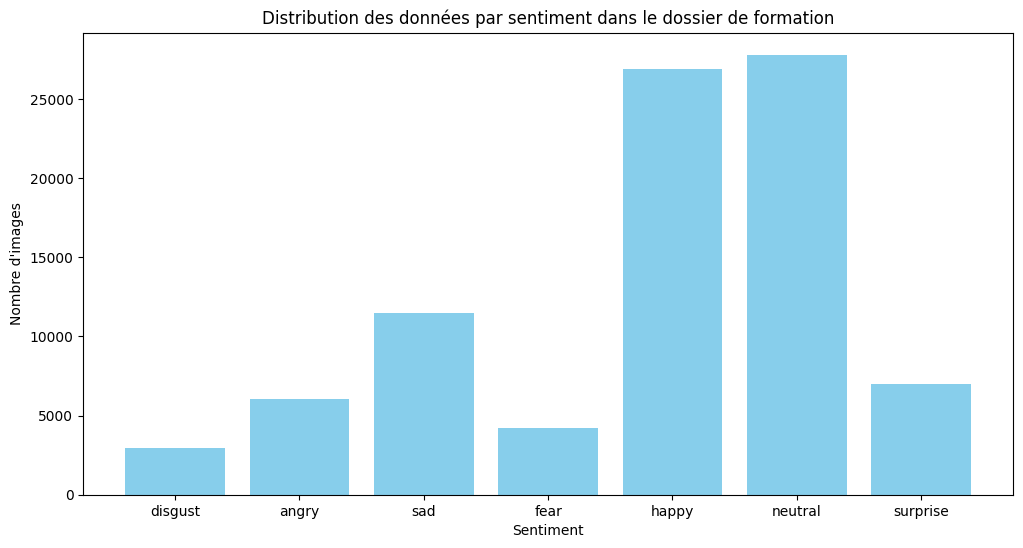

{'disgust': 2958, 'angry': 6077, 'sad': 11451, 'fear': 4241, 'happy': 26916, 'neutral': 27798, 'surprise': 7016}


In [ ]:
#Récupérer les noms des sous-dossiers dans le chemin train_path
sentiments = os.listdir(train_path)
#Compter le nombre d'images par catégorie
sentiment_count = {}

for sentiment in sentiments:
    images = os.listdir(os.path.join(train_path, sentiment))
    sentiment_count[sentiment] = len(images)


# Afficher la distribution sous forme de graphique à barres
plt.figure(figsize=(12, 6))
plt.bar(sentiment_count.keys(), sentiment_count.values(), color='skyblue')
plt.xlabel('Sentiment')
plt.ylabel('Nombre d\'images')
plt.title('Distribution des données par sentiment dans le dossier de formation')
plt.show()
print(sentiment_count)


In [ ]:
#Data Augment for angry
# Set the path to your image folder
folder_path = '/content/content/MMAFEDB/train/angry'

# Create an ImageDataGenerator with desired augmentations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# List all image files in the folder
image_files = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if img.endswith('.jpg')]

# Choose the number of augmented images you want
target_count = 20821
augmented_count = 0

# Keep augmenting until you reach the target count
while augmented_count < target_count:
    for img_path in image_files:
        # Load the image and convert it to a numpy array
        img = load_img(img_path)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        # Generate augmented images
        for batch in datagen.flow(x, batch_size=1, save_to_dir=folder_path, save_prefix='aug', save_format='jpg'):
            augmented_count += 1
            if augmented_count >= target_count:
                break  # Break out of the loop when reaching the target count

In [ ]:
# Set the path to your image folder
folder_path = '/content/content/MMAFEDB/train/disgust'

# Create an ImageDataGenerator with desired augmentations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# List all image files in the folder
image_files = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if img.endswith('.jpg')]

# Choose the number of augmented images you want
target_count =900821
augmented_count = 0

# Keep augmenting until you reach the target count
while augmented_count < target_count:
    for img_path in image_files:
        # Load the image and convert it to a numpy array
        img = load_img(img_path)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        # Generate augmented images
        for batch in datagen.flow(x, batch_size=1, save_to_dir=folder_path, save_prefix='aug', save_format='jpg'):
            augmented_count += 1
            if augmented_count >= target_count:
                break  # Break out of the loop when reaching the target count

In [ ]:
# Set the path to your image folder
folder_path = '/content/content/MMAFEDB/train/sad'

# Create an ImageDataGenerator with desired augmentations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# List all image files in the folder
image_files = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if img.endswith('.jpg')]

# Choose the number of augmented images you want
target_count =16347
augmented_count = 0

# Keep augmenting until you reach the target count
while augmented_count < target_count:
    for img_path in image_files:
        # Load the image and convert it to a numpy array
        img = load_img(img_path)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        # Generate augmented images
        for batch in datagen.flow(x, batch_size=1, save_to_dir=folder_path, save_prefix='aug', save_format='jpg'):
            augmented_count += 1
            if augmented_count >= target_count:
                break  # Break out of the loop when reaching the target count

In [ ]:
# Set the path to your image folder
folder_path = '/content/content/MMAFEDB/train/fear'

# Create an ImageDataGenerator with desired augmentations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# List all image files in the folder
image_files = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if img.endswith('.jpg')]

# Choose the number of augmented images you want
target_count = 23537
augmented_count = 0

# Keep augmenting until you reach the target count
while augmented_count < target_count:
    for img_path in image_files:
        # Load the image and convert it to a numpy array
        img = load_img(img_path)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        # Generate augmented images
        for batch in datagen.flow(x, batch_size=1, save_to_dir=folder_path, save_prefix='aug', save_format='jpg'):
            augmented_count += 1
            if augmented_count >= target_count:
                break  # Break out of the loop when reaching the target count

In [ ]:
# Set the path to your image folder
folder_path = '/content/content/MMAFEDB/train/surprise'

# Create an ImageDataGenerator with desired augmentations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# List all image files in the folder
image_files = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if img.endswith('.jpg')]

# Choose the number of augmented images you want
target_count = 19982
augmented_count = 0

# Keep augmenting until you reach the target count
while augmented_count < target_count:
    for img_path in image_files:
        # Load the image and convert it to a numpy array
        img = load_img(img_path)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        # Generate augmented images
        for batch in datagen.flow(x, batch_size=1, save_to_dir=folder_path, save_prefix='aug', save_format='jpg'):
            augmented_count += 1
            if augmented_count >= target_count:
                break  # Break out of the loop when reaching the target count

In [ ]:
# Parcourt récursivement le répertoire de l'ensemble d'entraînement pour compter toutes les images
train_image_count = sum(len(files) for _, _, files in os.walk(train_path))
# Parcourt récursivement le répertoire de l'ensemble de test pour compter toutes les images
test_image_count = sum(len(files) for _, _, files in os.walk(test_path))

# Affiche le nombre total d'images dans l'ensemble d'entraînement
print(f"Nombre d'images dans l'ensemble d'entraînement : {train_image_count}")
# Affiche le nombre total d'images dans l'ensemble de test
print(f"Nombre d'images dans l'ensemble de test : {test_image_count}")


Nombre d'images dans l'ensemble d'entraînement : 133897
Nombre d'images dans l'ensemble de test : 16758


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os

# Définition des dimensions des images et de la taille de batch
picture_size = (48, 48)  # Les images seront redimensionnées à 48x48 pixels
batch_size = 128  # Nombre d'images à traiter par lot pendant l'entraînement

# Création d'un générateur de données pour l'ensemble d'entraînement
datagen_train = ImageDataGenerator()

# Création d'un générateur de données pour l'ensemble de validation/test
datagen_val = ImageDataGenerator()


train_set = datagen_train.flow_from_directory(
    train_path,                # Chemin vers le répertoire contenant les données d'entraînement
    target_size=picture_size,  # Redimensionne toutes les images à 48x48 pixels
    color_mode="grayscale",    # Convertit les images en niveaux de gris
    batch_size=batch_size,     # Nombre d'images par lot
    class_mode="categorical",  # Les étiquettes seront encodées au format "one-hot"
    shuffle=True               # Les images sont mélangées à chaque itération
)


test_set = datagen_val.flow_from_directory(
    test_path,                 # Chemin vers le répertoire contenant les données de test
    target_size=picture_size,  # Redimensionne toutes les images à 48x48 pixels
    color_mode="grayscale",    # Convertit les images en niveaux de gris
    batch_size=batch_size,     # Nombre d'images par lot
    class_mode="categorical",  # Les étiquettes seront encodées au format "one-hot"
    shuffle=False              # Les données ne sont pas mélangées pour garantir un ordre cohérent
)


Found 133897 images belonging to 7 classes.
Found 16758 images belonging to 7 classes.


In [ ]:
# Nombre de classes (émotions) dans les données
no_of_classes = 7

# Récupération des étiquettes de classes à partir de l'ensemble d'entraînement
class_labels = train_set.classes  # Étiquettes des images dans les données d'entraînement
classes = np.unique(class_labels)  # Liste des classes uniques
# Calcul des pondérations des classes pour gérer les déséquilibres dans les données
class_weights = compute_class_weight('balanced', classes=classes, y=class_labels)
# Conversion des pondérations en dictionnaire pour une utilisation ultérieure
class_weight_dict = dict(enumerate(class_weights))

# Initialisation du modèle séquentiel
model = Sequential()

# 1ère couche convolutive
model.add(Conv2D(64, (3, 3), padding="same", input_shape=(48, 48, 1)))  # 64 filtres 3x3, image d'entrée 48x48x1
model.add(BatchNormalization())  # Normalisation des activations pour stabiliser l'entraînement
model.add(Activation("relu"))  # Fonction d'activation ReLU pour introduire de la non-linéarité
model.add(MaxPooling2D(pool_size=(2, 2)))  # Réduction de la taille spatiale par sous-échantillonnage (2x2)
model.add(Dropout(0.25))  # Régularisation avec Dropout pour éviter le surapprentissage

# 2ème couche convolutive
model.add(Conv2D(128, (5, 5), padding="same"))  # 128 filtres 5x5
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3ème couche convolutive
model.add(Conv2D(512, (3, 3), padding="same"))  # 512 filtres 3x3
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4ème couche convolutive
model.add(Conv2D(512, (3, 3), padding='same'))  # 512 filtres 3x3
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 5ème couche convolutive
model.add(Conv2D(512, (3, 3), padding='same'))  # 512 filtres 3x3
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Aplatissement des caractéristiques extraites (conversion en vecteur 1D)
model.add(Flatten())

# 1ère couche dense (entièrement connectée) avec régularisation L2
model.add(Dense(256, kernel_regularizer=l2(0.001)))  # 256 neurones avec régularisation L2
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))  # Dropout de 50 % pour éviter le surapprentissage

# 2ème couche dense avec régularisation L2
model.add(Dense(512, kernel_regularizer=l2(0.001)))  # 512 neurones
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# 3ème couche dense avec régularisation L2
model.add(Dense(512, kernel_regularizer=l2(0.001)))  # 512 neurones
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Couche de sortie (classification)
model.add(Dense(no_of_classes, activation="softmax"))  # 7 classes avec activation softmax pour la classification multiclass

# Résumé du modèle (affiche la structure)
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6, 6, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 6,056,711 (23.10 MB)

 Trainable params: 6,050,695 (23.08 MB)

 Non-trainable params: 6,016 (23.50 KB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, TensorBoard
from tensorflow.keras.optimizers import RMSprop

checkpoint = ModelCheckpoint("./face_emotion_model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0.001,
                          patience=20,
                          verbose=1,
                          restore_best_weights=True)

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.001)

# Learning Rate Warm-up
warmup_epochs = 20
initial_lr = 0.001
final_lr = 0.01

def lr_scheduler(epoch, lr):
    if epoch < warmup_epochs:
        lr = initial_lr + epoch * ((final_lr - initial_lr) / warmup_epochs)
    return lr

scheduler = LearningRateScheduler(lr_scheduler)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate, scheduler, tensorboard]

epochs = 200

optimizer = RMSprop(learning_rate=initial_lr)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_set,
                                steps_per_epoch=train_set.n//train_set.batch_size,
                                epochs=epochs,
                                validation_data = test_set,
                                validation_steps = test_set.n//test_set.batch_size,
                                class_weight=class_weight_dict,
                                callbacks=callbacks_list

                                )

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1046/1046 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3789 - loss: 2.5108
Epoch 1: val_accuracy improved from -inf to 0.44417, saving model to ./face_emotion_model.keras
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 103s 79ms/step - accuracy: 0.3790 - loss: 2.5102 - val_accuracy: 0.4442 - val_loss: 1.6167 - learning_rate: 0.0010
Epoch 2/200
   1/1046 ━━━━━━━━━━━━━━━━━━━━ 54s 52ms/step - accuracy: 0.5703 - loss: 1.3404

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy improved from 0.44417 to 0.67797, saving model to ./face_emotion_model.keras
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5703 - loss: 1.3404 - val_accuracy: 0.6780 - val_loss: 1.3705 - learning_rate: 0.0014
Epoch 3/200
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5661 - loss: 1.3387
Epoch 3: val_accuracy did not improve from 0.67797
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 112s 71ms/step - accuracy: 0.5661 - loss: 1.3387 - val_accuracy: 0.4711 - val_loss: 1.6264 - learning_rate: 0.0019
Epoch 4/200
   1/1046 ━━━━━━━━━━━━━━━━━━━━ 52s 51ms/step - accuracy: 0.5547 - loss: 1.2909
Epoch 4: val_accuracy did not improve from 0.67797
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 0s 42us/step - accuracy: 0.5547 - loss: 1.2909 - val_accuracy: 0.4746 - val_loss: 1.9428 - learning_rate: 0.0023
Epoch 5/200
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5969 - loss: 1.3035
Epoch 5: val_accuracy did not improve from 0.67797
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 82s 70ms/ste

In [ ]:
#Here is to save the model after the trainining and dont foget to downloaded in the local after it is saved
model.save('emotion_model.h5')

In [ ]:
# Generate predictions for the test set
predictions = model.predict(test_set)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Convert true labels to class labels
true_labels = test_set.classes

# Get class names
class_names = list(test_set.class_indices.keys())

# Print classification report
print("Classification Report:\n", classification_report(true_labels, predicted_labels, target_names=class_names))

131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step
Classification Report:
               precision    recall  f1-score   support

       angry       0.44      0.61      0.51      1010
     disgust       0.00      0.00      0.00       639
        fear       0.26      0.32      0.29       671
       happy       0.86      0.46      0.60      5150
     neutral       0.53      0.80      0.64      5742
         sad       0.46      0.27      0.34      2108
    surprise       0.48      0.64      0.55      1438

    accuracy                           0.55     16758
   macro avg       0.43      0.44      0.42     16758
weighted avg       0.58      0.55      0.54     16758



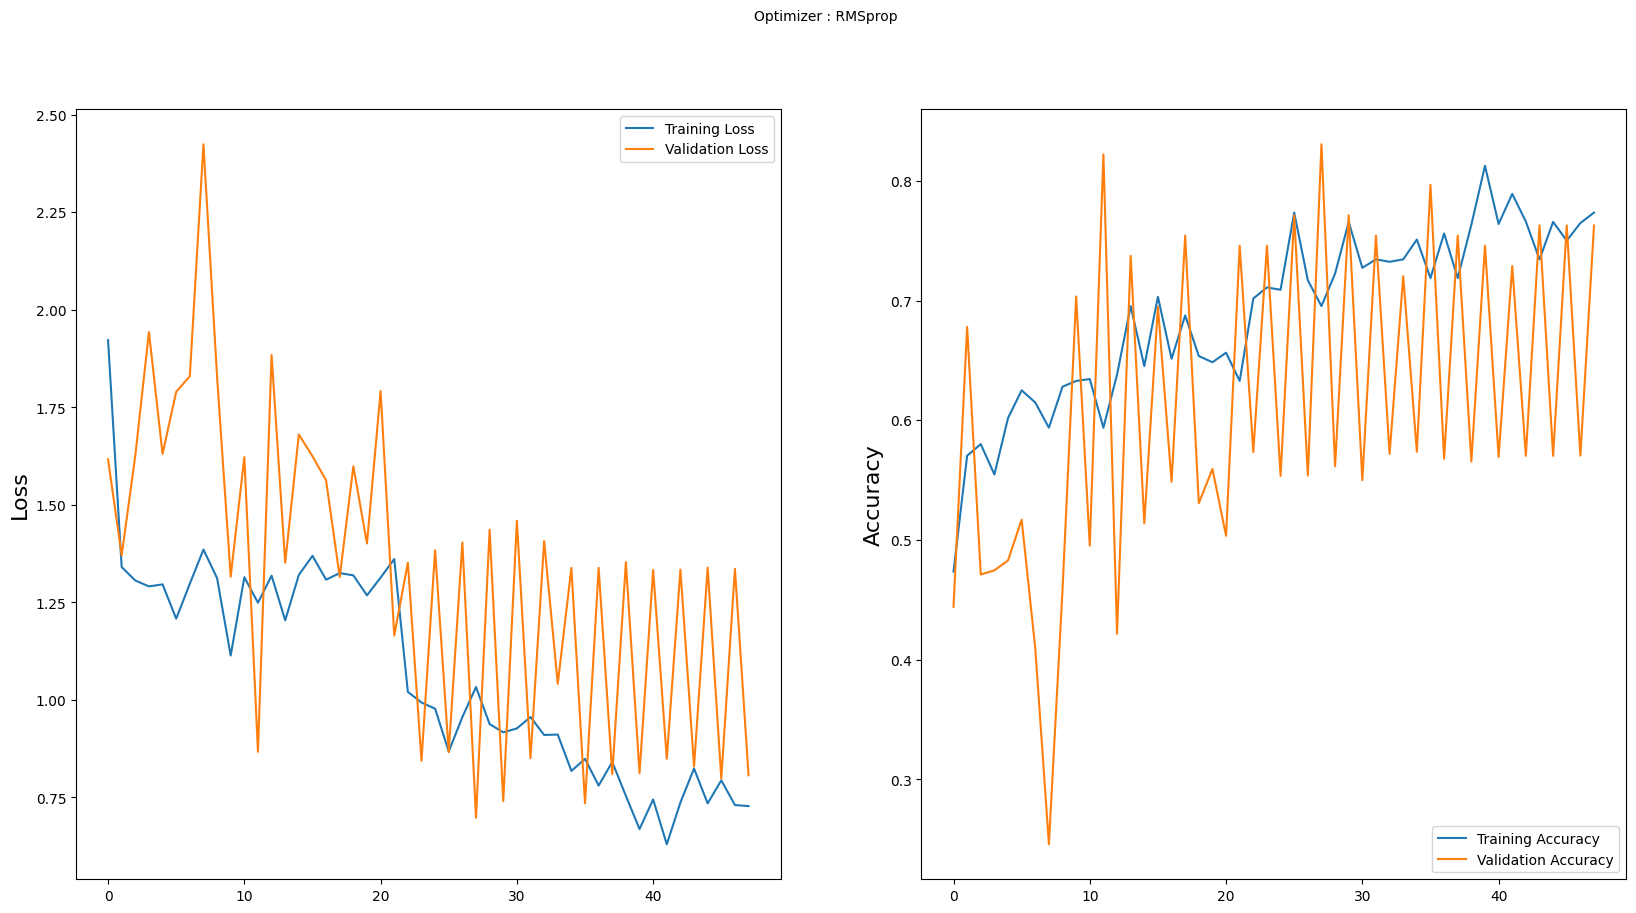

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : RMSprop', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step


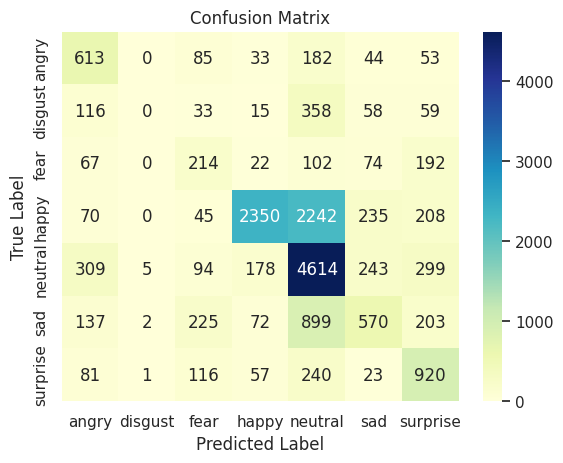

In [ ]:
# Get the true labels and predicted labels for the validation set
validation_labels = test_set.classes
validation_pred_probs = model.predict(test_set)
validation_pred_labels = np.argmax(validation_pred_probs, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(validation_labels, validation_pred_labels)
class_names = list(train_set.class_indices.keys())
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_set, steps=test_set.n // test_set.batch_size)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.4782 - loss: 1.5997
Test Loss: 1.4285
Test Accuracy: 0.5519


In [ ]:
pip install opencv-python

In [ ]:
from keras.models import load_model


emotion_model = load_model('/content/drive/MyDrive/Vision/emotion_model.h5')



In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
def extract_faces(image_path):
    # Load the pre-trained face detector
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Read the image
    image = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    # Extract and save faces
    for i, (x, y, w, h) in enumerate(faces):
        face = image[y:y+h, x:x+w]

    return face

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


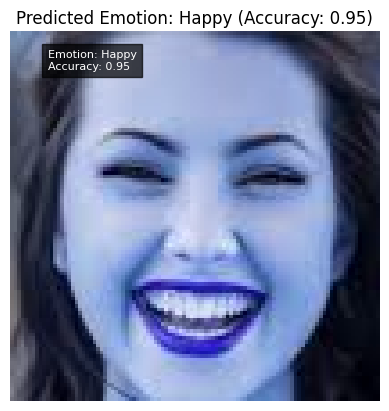

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def extract_faces(image_path):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    extracted_faces = []
    for (x, y, w, h) in faces:
        face = image[y:y+h, x:x+w]
        extracted_faces.append(face)

    return extracted_faces


# Specify the input image path
image_path = "/content/drive/MyDrive/Vision/img.jpg"
emotion_dict = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}
# Extract faces from the photo
faces = extract_faces(image_path)

# Display or further process the extracted faces
for i, face in enumerate(faces):
    # Resize the face to the required input size for the emotion model
    face_resized = cv2.resize(face, (48, 48))

    # Convert the resized face to grayscale
    face_resized_gray = cv2.cvtColor(face_resized, cv2.COLOR_BGR2GRAY)

    # Reshape the image for prediction
    img = np.expand_dims(face_resized_gray, axis=0)
    img = np.expand_dims(img, axis=-1)

    # Make predictions on the extracted face
    predictions = emotion_model.predict(img)
    predicted_class = np.argmax(predictions)
    predicted_emotion = emotion_dict[predicted_class]
    accuracy = predictions[0][predicted_class]

    # Display the original face and predicted emotion
    plt.imshow(face)
    plt.title(f"Predicted Emotion: {predicted_emotion} (Accuracy: {accuracy:.2f})")
    plt.axis('off')

    # Add predicted emotion and accuracy as text on the image
    plt.text(10, 10, f"Emotion: {predicted_emotion}\nAccuracy: {accuracy:.2f}", color='white', fontsize=8, bbox=dict(facecolor='black', alpha=0.7))

    plt.show()